- [ ] To add livig_donor_type
    - add to nan handling
    - make sure that it does not destroy the dataset
    - make sure that it is in the dataset
    - train the best rsf with the updated dataset and compare results


In [1]:
import os
os.chdir('/mnt/lustre/helios-home/stadnkyr')
print(os.getcwd())

import logging
from typing import Tuple
import pickle
import datetime

import pandas as pd
import numpy as np
from sksurv.column import encode_categorical
from sksurv.column import standardize
from sksurv.util import Surv

# from columns import COLUMNS
from surv_data_pipeline.columns import COLUMNS
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest


logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(message)s')
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)


class ScikitSurvivalDataLoader:
    df = None
    target = None

    ''' ideas
     - return already smaller dataset with df = df.sample(frac=1).reset_index(drop=True) (draws sample percentage of the dataset)
     - return another variable - validation set (or do that in code itself)
     - add self.validation_set - without filling nan values with median
     - try to train only on newer transplantations - today the chances of survival are much higher than it was in 80s.
     - try to add kidney compatibility indices
     - make defining of the features only here and not to use columns.py
    '''

    yes_categorical=[
                    "PRE_TX_TXFUS", "AGE_GROUP", "DON_TY",  
                    "GENDER",
                    "ON_DIALYSIS", 
                    # "ABO_MAT", 
                    # 'HBV_CORE', 
                    "ETHCAT", 
                    "ETHCAT_DON",
                    'DIAB',
                    'HCV_SEROSTATUS',  
                    'LIV_DON_TY',

                ]
    yes_numerical = [
                    "SERUM_CREAT",
                    "AGE", 
                    "AGE_DON",
                    "TX_DATE", "DIALYSIS_DATE", #'KDPI', 'KDRI_RAO'
                    # "KI_CREAT_PREOP",
                    # "NPKID", 
                    # "HGT_CM_CALC", 
                    # "BMI_DON_CALC",
                    ]

    def __init__(self, patient_survival: bool = True) -> None:
        self.target = ["PTIME", "PSTATUS"] 

        self.yes_numerical.insert(0,self.target[1])
        self.yes_numerical.insert(0,self.target[0])

    def load(self, n_samples_to_load=None, fill_na_with_median:bool = True) -> Tuple[pd.DataFrame, any]:
        self._load_pd_df()
        self._apply_exclusion_criteria()

        if n_samples_to_load is not None:
            self.df = self.df.sample(n_samples_to_load, random_state=42)

        # self._divide_train_test_validation()

        self.df = self._handle_nan(fill_na_with_median)
        # self.test = self._handle_nan(fill_na_with_median, self.test)
        # self.validate = self._handle_nan(fill_na_with_median, self.validate)

        return self._get_X_y()
    
    def get_test_X_y(self):
        return self._get_X_y(self.test)

    def get_validate_X_y(self):
        return self._get_X_y(self.validate)
    
    def _divide_train_test_validation(self):
        self.test = None
        self.validate = None

        logger.info("Dividing the dataset into train, test and validation sets...")

        self.df, self.test = train_test_split(self.df, test_size=0.2, 
                                                       random_state=42)
        
        # self.df, test_validation_df = train_test_split(self.df, test_size=0.3, 
        #                                                random_state=42, 
        #                                                stratify=self.df['PSTATUS'])

        # self.test, self.validate = train_test_split(test_validation_df, 
        #                                             test_size=0.5, 
        #                                             random_state=42, 
        #                                             stratify=self.df['PSTATUS'])

        logger.info("Done!")

    def _load_pd_df(self, columns = COLUMNS):
        logger.info("Loading data into pandas DataFrame...")
        self.df = pd.read_parquet(
            "/mnt/lustre/helios-home/stadnkyr/Kidney_transplants.parquet", 
            engine='auto', columns=list(set(columns+self.yes_categorical+self.yes_numerical)))

        logger.info(f"Done! Loaded df of shape {self.df.shape}")

    def _apply_exclusion_criteria(self):
        '''
        ideas: try to censor unrelated reasons
        '''
        UNRELATED_COD = {998,999, 2801,2803,8065,8064,8063,8062,8050,7237, 7226, 
                         7227, 6853,5808,3899, 3800}
        
        self.df = self.df[self.df['PSTATUS'].notnull()]
        self.df = self.df[self.df['AGE_GROUP'] == "A"]
        self.df = self.df[self.df['DON_TY'] != "F"]
        self.df = self.df[self.df['DIABETES_DON'] != "U"]
        self.df = self.df[self.df['PRE_TX_TXFUS'] != "U"]
        # self.df = self.df[self.df['HBV_CORE'] != "U"]
        # self.df = self.df[self.df['HBV_SUR_ANTIGEN'] != "U"]
        self.df = self.df[self.df['HCV_SEROSTATUS'] != "U"]
        # remove multiracial and unknowns
        self.df = self.df[self.df['ETHCAT'] != "998"]
        # self.df = self.df[self.df['LIV_DON_TY'] != "998"]
        # self.df = self.df[self.df['ETHCAT'] != "9"]

        self.df = self.df[self.df['DIAB'] != "998"]
        self.df = self.df[self.df['DIAB'] != 998]

        # remove death of unrelated  reasons
        mask = ~self.df['COD_KI'].isin(UNRELATED_COD)
        self.df = self.df[mask] 

        self.df = self.df[self.df['DON_TY'] == "L"] # living donor specification

        self.df['DIALYSIS_TIME'] = self.df.apply(lambda row: 
                                                 self._get_difference_in_days(row['DIALYSIS_DATE'], row['TX_DATE']) 
                                                 if row['DIALYSIS_DATE'] is not None and row['TX_DATE'] 
                                                 is not None else 0, axis=1)

        self.yes_numerical = [x for x in self.yes_numerical if x != 'DIALYSIS_DATE' and x != "TX_DATE"]
        self.yes_numerical.append('DIALYSIS_TIME')

        logger.info(f"{self.df.shape}")

    def _handle_nan(self, fill_na_with_median:bool, dataset = None):
        '''
        evaluation set should not have values that were calculated
        '''
        if dataset is None:
            dataset = self.df
            fill_na_with_median=False
        else:
            fill_na_with_median=False

        if fill_na_with_median:
            logger.info("Handling nan values...")
        else:
            logger.info("Dropping nan values...")
        
        # print(dataset.shape)
        self.yes_categorical = [item for item in self.yes_categorical if item !="COD_KI"]
        dataset.dropna(subset=list(set(self.yes_categorical+self.yes_numerical)), inplace=True)

        dataset.dropna(subset=self.yes_numerical, inplace=True)
        # print(dataset.shape)
        logger.info("Done!")
        return dataset

    def _get_X_y(self, dataset = None) -> Tuple[pd.DataFrame, any]:
        if dataset is None:
            dataset = self.df
        logger.info("Dividing data into X and y...")

        with open('pickle/COX_DATA_FULL_LIVING.pkl', 'wb') as file:
            pickle.dump(dataset, file)

        categorical_x = encode_categorical(dataset[self.yes_categorical])
        numerical_x = standardize(dataset[self.yes_numerical])

        X = pd.concat([numerical_x, categorical_x], axis=1)
        X.drop([self.target[0], self.target[1]], axis=1, inplace=True)

        survival_time = dataset[self.target[0]].astype(np.float64)
        event = dataset[self.target[1]].astype(float).astype(np.bool)

        y = Surv.from_arrays(event, survival_time, "Status", "Days")

        self.df = None

        logger.info("Done!")

        return X, y
    
    def _calculate_egfr(self, creatinine, age, gender, race):
        pass

    def _get_difference_in_days(self, date1, date2):
        date1_dict = eval(str(date1))
        date2_dict = eval(str(date2))
        
        date1 = date1_dict['$date']
        date2 = date2_dict['$date']

        if isinstance(date1, str) and (date2, str):
            date1_object = datetime.datetime.strptime(date1, "%Y-%m-%dT%H:%M:%SZ")
            date2_object = datetime.datetime.strptime(date2, "%Y-%m-%dT%H:%M:%SZ")

            difference = date2_object - date1_object
            return difference.days
        else:
            return

/mnt/lustre/helios-home/stadnkyr


In [2]:
loader = ScikitSurvivalDataLoader()

X, y = loader.load()

2024-02-24 21:52:23,277 - Loading data into pandas DataFrame...
2024-02-24 21:52:53,568 - Done! Loaded df of shape (993806, 57)
2024-02-24 21:53:03,994 - (112949, 58)
2024-02-24 21:53:03,996 - Dropping nan values...
2024-02-24 21:53:04,296 - Done!
2024-02-24 21:53:04,298 - Dividing data into X and y...
dropped categorical variable 'AGE_GROUP', because it has only 1 values
dropped categorical variable 'DON_TY', because it has only 1 values
2024-02-24 21:53:04,600 - Done!


In [3]:
X.shape

(61545, 39)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y["Status"], random_state=42)

# RSF fine-tuning

In [29]:
from tqdm.notebook import tqdm
from sksurv.metrics import concordance_index_ipcw

train_num = 1000
test_num = 100

n_estimators = [50,] # 1, 5, 10, 30, 50, 70]
max_depth = [12] # 2,4, 6, 8, 10, 12, 14 # picked
min_samples_split = [16] # 2, 4, 6, 8  10, 12, 14, 16, 18 # picked
max_features = [ None]

lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

rsf = RandomSurvivalForest(n_jobs=-1)

best_rsf_model = None
highest_cindex = 0
best_params = None

pbar = tqdm(total = len(n_estimators)*len(max_depth)*len(min_samples_split)*len(max_features), desc='Hyperparameter Tuning')

for n_estimator in n_estimators:
    for depth in max_depth:
        for split in min_samples_split:
            for feature in max_features:
                rsf.set_params(n_estimators=n_estimator, max_depth=depth, min_samples_split=split, max_features=feature)
                rsf.fit(X_train[train_num:], y_train[train_num:])
                pred = rsf.predict(X_test[test_num:])
                uno_concordance = concordance_index_ipcw(y_train[train_num:], y_test[test_num:], pred, tau=times[-1])
                uno = float(uno_concordance[0])
                if uno > highest_cindex:
                    highest_cindex = uno
                    best_params = (n_estimator, depth, split, feature)
                    best_rsf_model = rsf
                pbar.update(1)

Hyperparameter Tuning:   0%|          | 0/3 [00:00<?, ?it/s]

In [30]:
print(f"Best params: {best_params}")
print(f"Best Uno: {highest_cindex}")

Best params: (50, 12, 16, None)
Best Uno: 0.7228909778597444


Best params: (10, 6, 4, None)
Best Uno: 0.7116080806020363 - 33min on 1000 records, 18 iterations

Best params: (10, 10, 6, None)
Best Uno: 0.7191111961388634

Best params: (50, 10, 8, None)
Best Uno: 0.7231445056145038

Best params: (50, 12, 14, None)
Best Uno: 0.7225197045158794 // 0.7730664440676259 on unseen data

Best params: (50, 12, 16, None)
Best Uno: 0.7228909778597444 // 0.723011869663161 on the whole test set
the first observation - RSF is able to learn to generalize pretty well on small amount of data (1000 samples)

In [31]:
pred = rsf.predict(X_test)
uno_concordance = concordance_index_ipcw(y_train[train_num:], y_test, pred, tau=times[-1])
uno = float(uno_concordance[0])
uno

0.723011869663161

## RSF train

In [32]:
best_rsf = RandomSurvivalForest(n_estimators=50, max_depth=12, min_samples_split=16, max_features=None)
best_rsf.fit(X_train, y_train)

RandomSurvivalForest(max_depth=12, max_features=None, min_samples_split=16,
                     n_estimators=50)

In [33]:
pred = best_rsf.predict(X_test)
uno_concordance = concordance_index_ipcw(y_train, y_test, pred, tau=times[-1])
uno = float(uno_concordance[0])
uno

0.7228369196476826

In [37]:
from sksurv.metrics import brier_score, integrated_brier_score

# surv_fn = best_rsf.predict_survival_function(X_test, return_array=False)
surv_fn = rsf.predict_survival_function(X_test, return_array=False)

surv_prob = np.row_stack([fn(times) for fn in surv_fn])

bs = brier_score(y_train, y_test, surv_prob, times)
ibs = integrated_brier_score(y_train, y_test, surv_prob, times)#times)
print('Integrated Brier Score:', ibs)

# full model: Integrated Brier Score: 0.13900993221935395
# 1000 instances: Integrated Brier Score: 0.1390655175499429

Integrated Brier Score: 0.1390655175499429


### RSF on small amount of samples

In [5]:
rsf100 = RandomSurvivalForest(n_estimators=80, max_depth=12, min_samples_split=16, max_features=None)
rsf100.fit(X_train[1500:], y_train[1500:])

RandomSurvivalForest(max_depth=12, max_features=None, min_samples_split=16,
                     n_estimators=80)

In [9]:
from sksurv.metrics import (
    concordance_index_ipcw,
    integrated_brier_score,
    brier_score
)

lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

pred = rsf100.predict(X_test)
uno_concordance = concordance_index_ipcw(y_train, y_test, pred, tau=times[-1])
uno = float(uno_concordance[0])
print("Uno Concordance: ", uno)

surv_fn = rsf100.predict_survival_function(X_test, return_array=False)
surv_prob = np.row_stack([fn(times) for fn in surv_fn])

bs = brier_score(y_train, y_test, surv_prob, times)
ibs = integrated_brier_score(y_train, y_test, surv_prob, times)#times)
print('Integrated Brier Score:', ibs)

Uno Concordance:  0.7228517146540674
Integrated Brier Score: 0.13903697824746727


Upping estimators does not make sense. No change for too much time.
Small training set 

In [35]:
# import pickle

# with open('pickle/models/RSF_LIVING_FINAL.pkl', 'wb') as file:
#             pickle.dump(best_rsf, file)

# COXNET

In [ ]:
from sksurv.linear_model import CoxnetSurvivalAnalysis

cox = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100)
cox.fit(X_train, y_train)

estimated_alphas = cox.alphas_
l1_ratios = [0.0001]

/mnt/lustre/helios-home/stadnkyr/jupyter_virtual_env/lib64/python3.6/site-packages/ipykernel_launcher.py:4: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100).
  after removing the cwd from sys.path.


In [ ]:
from tqdm.notebook import tqdm
from surv_data_pipeline.estimator_evaluation import SurvivalEstimatorEvaluation

best_params = None
highest_cindex=0

lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

cox_grid=CoxnetSurvivalAnalysis()

pbar = tqdm(total = len(estimated_alphas)*len(l1_ratios), desc='Hyperparameter Tuning')

for ratio in l1_ratios:
    for alpha in estimated_alphas:
        cox_grid.set_params(l1_ratio=ratio, alphas=[alpha])

        cox_grid.fit(X_train, y_train)
        uno_score = SurvivalEstimatorEvaluation.evaluate_model_uno_c(cox_grid, X_test, y_test, y_train, times)

        uno = float(uno_score[0])
        if uno > highest_cindex:
            highest_cindex = uno
            best_params = (ratio, alpha)
            best_rsf_model = cox_grid

        # Update the progress bar
        pbar.update()

Hyperparameter Tuning:   0%|          | 0/62 [00:00<?, ?it/s]

In [ ]:
highest_cindex

0.7027093682996722

In [ ]:
best_params

(0.0001, 0.16961976023444314)

In [ ]:
fixed_best_params = (0.001, 0.12078532560892971)
coxnet_pred = CoxnetSurvivalAnalysis(l1_ratio=fixed_best_params[0],alphas=[fixed_best_params[1]], fit_baseline_model=True)
# coxnet_pred = CoxnetSurvivalAnalysis(l1_ratio=best_params[0],alphas=[best_params[1]], fit_baseline_model=True)
coxnet_pred.fit(X_train, y_train)

CoxnetSurvivalAnalysis(alphas=[0.12078532560892971], fit_baseline_model=True,
                       l1_ratio=0.001)

In [ ]:
from surv_data_pipeline.estimator_evaluation import SurvivalEstimatorEvaluation

lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

SurvivalEstimatorEvaluation.evaluate_model_uno_c(coxnet_pred, X_test, y_test, y_train, times)

(0.7051079287152411, 13464745, 5690651, 1, 3954)

0.712


In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(coxnet_pred, X_test[:5000], y_test[:5000], n_repeats=5, random_state=0, n_jobs=1)

In [ ]:
pd.set_option('display.max_rows', 500)

importances_df = pd.DataFrame(result.importances_mean, index=X.columns)
importances_df.columns = ['Importance']
importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print out feature importances
importances_df

In [ ]:
pd.set_option('display.max_rows', 500)
SurvivalEstimatorEvaluation.print_feature_importances(coxnet_pred, X_test, y_test)
# SurvivalEstimatorEvaluation.print_feature_importances(coxnet_pred, X_test[1000:], y_test[1000:])

In [ ]:
adfs

NameError: name 'adfs' is not defined

## Summer work

In [ ]:
from sklearn.model_selection import train_test_split
from surv_data_pipeline.estimator_evaluation import SurvivalEstimatorEvaluation

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
    brier_score
)
import matplotlib.pyplot as plt


def train_model(model, x, y):
    lower, upper = np.percentile(y["Days"], [10, 90])
    times = np.arange(lower, upper + 1)

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42)

    model.fit(X_train, y_train, fit_baseline_model=True)
    # model.fit(X_train, y_train)

    # score = model.score(X_test, y_test)
    # print("Model's score: ", round(score, 3))

    # uno_score = SurvivalEstimatorEvaluation.evaluate_model_uno_c(model, X_test, y_test, y_train, times)
    # print("Uno's score: ", round(uno_score[0], 3))
    # auc_score, mean_auc = SurvivalEstimatorEvaluation.evaluate_model_auc(model, X_test.iloc[:5000], y_test[:5000], y, times)
    # print("Mean AUC: ", round(mean_auc, 3))

    lower, upper = np.percentile(y["Days"], [10, 90])
    times = np.arange(lower, upper + 1)

    surv = model.predict_survival_function(X_test)#, return_array=False)
    surv_prob = np.row_stack([fn(times) for fn in surv])

    ibs = integrated_brier_score(y_train, y_test, surv_prob, times)#best_rsf.event_times_)
    # print('Integrated Brier Score:', round(ibs,3))
    # print('Integrated Brier Score:', ibs)

    return model, ibs#, ibs

In [ ]:
def plot_time_dependent_auc(model, x_test, y_test, y_train, name=None):
    lower, upper = np.percentile(y_train["Days"], [10, 90])
    times = np.arange(lower, upper + 1)
    print("predicting....")
    cph_risk_scores = model.predict(x_test)
    print("calculating auc...")
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, cph_risk_scores, times)
    print("plotting inside...")
    plt.plot(times, auc, marker="o")
    plt.axhline(mean_auc, linestyle="--")
    # plt.text(5, 0, "{model}", fontsize=12)
    plt.xlabel("days")
    plt.ylabel("time-dependent AUC")
    plt.grid(True)
    if name is not None:
        plt.savefig(f"/mnt/lustre/helios-home/stadnkyr/AUC_results/{name}_MAUC_{mean_auc}.png")
    plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
import matplotlib.pyplot as plt


In [ ]:
loader = ScikitSurvivalDataLoader()

X, y = loader.load()

2023-12-05 12:26:55,935 - Loading data into pandas DataFrame...
2023-12-05 12:27:17,388 - Done! Loaded df of shape (993806, 53)
2023-12-05 12:27:20,046 - (429588, 53)
2023-12-05 12:27:20,048 - Dividing the dataset into train, test and validation sets...
2023-12-05 12:27:20,961 - Done!
2023-12-05 12:27:20,962 - Dropping nan values...
2023-12-05 12:27:21,509 - Done!
2023-12-05 12:27:21,510 - Dropping nan values...
2023-12-05 12:27:21,627 - Done!
2023-12-05 12:27:21,628 - Dropping nan values...
2023-12-05 12:27:21,777 - Done!
2023-12-05 12:27:21,779 - Dividing data into X and y...
dropped categorical variable 'DON_TY', because it has only 1 values
dropped categorical variable 'AGE_GROUP', because it has only 1 values
2023-12-05 12:27:21,910 - Done!


In [ ]:
X.shape

(34951, 82)

In [ ]:
# stratify = y["event"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y["Status"], random_state=42)

In [ ]:
from sksurv.linear_model import CoxnetSurvivalAnalysis

cox = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100)
cox.fit(X_train, y_train)

estimated_alphas = cox.alphas_
l1_ratios = np.arange(0.1, 1.1, 0.1)

/mnt/lustre/helios-home/stadnkyr/jupyter_virtual_env/lib64/python3.6/site-packages/ipykernel_launcher.py:4: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100).
  after removing the cwd from sys.path.


In [ ]:
from tqdm import tqdm
from surv_data_pipeline.estimator_evaluation import SurvivalEstimatorEvaluation

best_params = None
highest_cindex=0

lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

cox_grid=CoxnetSurvivalAnalysis()

pbar = tqdm(total = len(estimated_alphas)*len(l1_ratios), desc='Hyperparameter Tuning')

for ratio in l1_ratios:
    for alpha in estimated_alphas:
        cox_grid.set_params(l1_ratio=ratio, alphas=[alpha])

        cox_grid.fit(X_train, y_train)
        uno_score = SurvivalEstimatorEvaluation.evaluate_model_uno_c(cox_grid, X_test, y_test, y_train, times)

        uno = float(uno_score[0])
        if uno > highest_cindex:
            highest_cindex = uno
            best_params = (ratio, alpha)
            best_rsf_model = cox_grid

        # Update the progress bar
        pbar.update()

Hyperparameter Tuning: 100%|██████████| 870/870 [08:12<00:00,  1.76it/s]

In [ ]:
highest_cindex

0.7077330240691684

In [ ]:
best_params

(0.1, 0.04825889367871719)

In [ ]:
coxnet_pred = CoxnetSurvivalAnalysis(l1_ratio=best_params[0],alphas=[best_params[1]], fit_baseline_model=True)
coxnet_pred.fit(X_train, y_train)

CoxnetSurvivalAnalysis(alphas=[0.04825889367871719], fit_baseline_model=True,
                       l1_ratio=0.1)

In [ ]:
SurvivalEstimatorEvaluation.evaluate_model_uno_c(coxnet_pred, X_test, y_test, y_train, times)

(0.7077330240691684, 5426784, 2278170, 0, 1730)

In [ ]:
import pickle

with open('pickle/COXNET_LIVING_MODEL.pickle', 'wb') as f:
    pickle.dump(coxnet_pred, f)

In [ ]:
best_rsf = RandomSurvivalForest(n_jobs=-1,
                              n_estimators=70,
                              max_depth=10,
                              min_samples_split=10,
                              max_features=None,
                               verbose=1
                              )
best_rsf.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


KeyboardInterrupt: 

In [ ]:
lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

SurvivalEstimatorEvaluation.evaluate_model_uno_c(best_rsf, X_test, y_test, y_train, times)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  70 out of  70 | elapsed:    1.7s finished


(0.7259655087331299, 5545230, 2159184, 540, 1730)

In [ ]:
auc_score, mean_auc = SurvivalEstimatorEvaluation.evaluate_model_auc(best_rsf, X_test, y_test, y_train, times)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  70 out of  70 | elapsed:    1.7s finished


Text(0, 0.5, 'Time-dependent AUC')

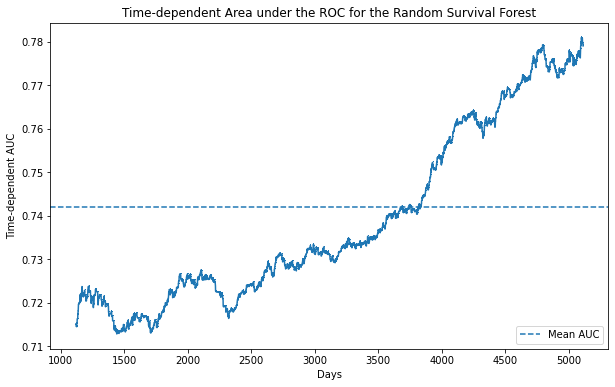

In [ ]:
#print AUC

plt.figure(figsize=(10,6))
plt.plot(times, auc_score, marker=",")
plt.axhline(mean_auc, linestyle="--", label="Mean AUC")
# plt.text(5, 0, "{model}", fontsize=12)
plt.title("Time-dependent Area under the ROC for the Random Survival Forest")
plt.xlabel("Days")
plt.legend(loc='lower right')
plt.ylabel("Time-dependent AUC")

In [ ]:
surv_fn = best_rsf.predict_survival_function(X_test, return_array=False)

surv_prob = np.row_stack([fn(times) for fn in surv_fn])

bs = brier_score(y_train, y_test, surv_prob, times)
ibs = integrated_brier_score(y_train, y_test, surv_prob, times)#times)
print('Integrated Brier Score:', ibs)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done  70 out of  70 | elapsed:    4.5s finished


Integrated Brier Score: 0.12877587894572215


Text(0, 0.5, 'time-dependent Brier Score')

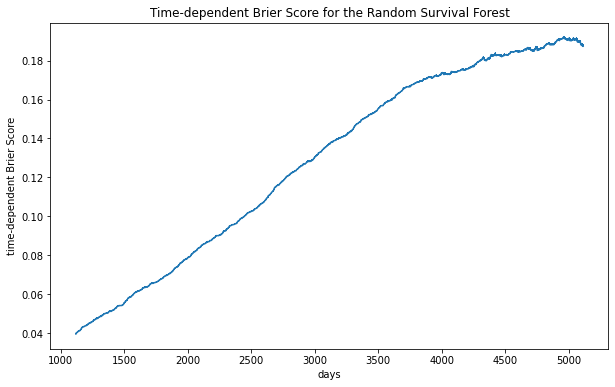

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(bs[0], bs[1], marker=",")
# plt.axhline(ibs, linestyle="--")
# plt.text(5, 0, "{model}", fontsize=12)
plt.title("Time-dependent Brier Score for the Random Survival Forest")
plt.xlabel("days")
plt.ylabel("time-dependent Brier Score")

In [ ]:
# SurvivalEstimatorEvaluation.print_feature_importances(best_rsf,X_train[500:],y_train[500:])

In [ ]:
# lower, upper = np.percentile(y["Days"], [10, 90])
# times = np.arange(lower, upper + 1)

# surv = best_rsf.predict_survival_function(X_test, return_array=False)

In [ ]:
# surv_prob = np.row_stack([fn(times) for fn in surv])

# ibs = integrated_brier_score(y_train, y_test, surv_prob, times)#best_rsf.event_times_)
# print('Integrated Brier Score:', round(ibs,3))


NameError: name 'x' is not defined

In [ ]:
from sksurv.linear_model import CoxnetSurvivalAnalysis

cox = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100)
cox.fit(X_train, y_train)


/mnt/lustre/helios-home/stadnkyr/jupyter_virtual_env/lib64/python3.6/site-packages/ipykernel_launcher.py:4: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100).
  after removing the cwd from sys.path.


CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9, max_iter=100)

In [ ]:
estimated_alphas = cox.alphas_
l1_ratios = np.arange(0.1, 1, 0.1)
l1_ratios

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [ ]:
from tqdm import tqdm

best_params = None
highest_cindex=0

cox_grid=CoxnetSurvivalAnalysis()

pbar = tqdm(total = len(estimated_alphas)*len(l1_ratios), desc='Hyperparameter Tuning')
for ratio in l1_ratios:
    for alpha in estimated_alphas:
        cox_grid.set_params(l1_ratio=ratio, alphas=[alpha])

        cox_grid.fit(X_train, y_train)
        uno_score = SurvivalEstimatorEvaluation.evaluate_model_uno_c(cox_grid, X_test, y_test, y_train, times)

        uno = float(uno_score[0])
        if uno > highest_cindex:
            highest_cindex = uno
            best_params = (ratio, alpha)
            best_rsf_model = cox_grid

        # Update the progress bar
        pbar.update()

Hyperparameter Tuning:   0%|          | 0/87 [00:52<?, ?it/s]


Hyperparameter Tuning: 696it [06:32,  1.77it/s]                       /mnt/lustre/helios-home/stadnkyr/jupyter_virtual_env/lib64/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: all coefficients are zero, consider decreasing alpha.
  del sys.path[0]
Hyperparameter Tuning: 783it [07:20,  1.75it/s]

In [ ]:
highest_cindex

0.7077310938443733

l_1 ratio: Uno: 0.689226981553399

In [ ]:
best_params

(0.1, 0.04825889367871719)

In [ ]:
coxnet_pred = CoxnetSurvivalAnalysis(l1_ratio=best_params[0],alphas=[best_params[1]], fit_baseline_model=True)
coxnet_pred.fit(X_train, y_train)

CoxnetSurvivalAnalysis(alphas=[0.04825889367871719], fit_baseline_model=True,
                       l1_ratio=0.1)

In [ ]:
cox_auc_score, cox_mean_auc = SurvivalEstimatorEvaluation.evaluate_model_auc(coxnet_pred, X_test, y_test, y_train, times)

Text(0, 0.5, 'Time-dependent AUC')

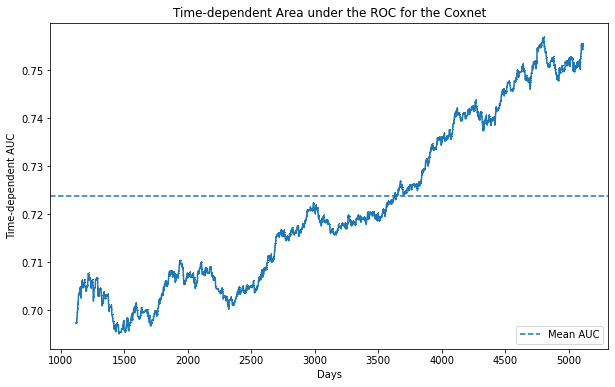

In [ ]:
# mean_auc
plt.figure(figsize=(10,6))
plt.plot(times, cox_auc_score, marker=",")
plt.axhline(cox_mean_auc, linestyle="--", label="Mean AUC")
# plt.text(5, 0, "{model}", fontsize=12)
plt.title("Time-dependent Area under the ROC for the Coxnet")
plt.xlabel("Days")
plt.legend(loc='lower right')
plt.ylabel("Time-dependent AUC")

In [ ]:
cox_surv_fn = coxnet_pred.predict_survival_function(X_test)

cox_surv_prob = np.row_stack([fn(times) for fn in cox_surv_fn])

cox_bs = brier_score(y_train, y_test, cox_surv_prob, times)
cox_ibs = integrated_brier_score(y_train, y_test, cox_surv_prob, times)#times)
print('Integrated Brier Score:', cox_ibs)

Integrated Brier Score: 0.13074072519101868


In [ ]:
import pickle

# cox_auc_score, cox_mean_auc
with open('pickle/cox_auc.pickle', 'wb') as f:
    pickle.dump((cox_auc_score, cox_mean_auc), f, protocol=pickle.HIGHEST_PROTOCOL)

# auc_score, mean_auc
with open('pickle/rsf_auc.pickle', 'wb') as f:
    pickle.dump((auc_score, mean_auc), f, protocol=pickle.HIGHEST_PROTOCOL)

# cox_bs
with open('pickle/cox_bs.pickle', 'wb') as f:
    pickle.dump(cox_bs, f, protocol=pickle.HIGHEST_PROTOCOL)

# bs
with open('pickle/rsf_bs.pickle', 'wb') as f:
    pickle.dump(bs, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('pickle/living_times.pickle', 'wb') as f:
    pickle.dump(times, f, protocol=pickle.HIGHEST_PROTOCOL)


Text(0, 0.5, 'time-dependent Brier Score')

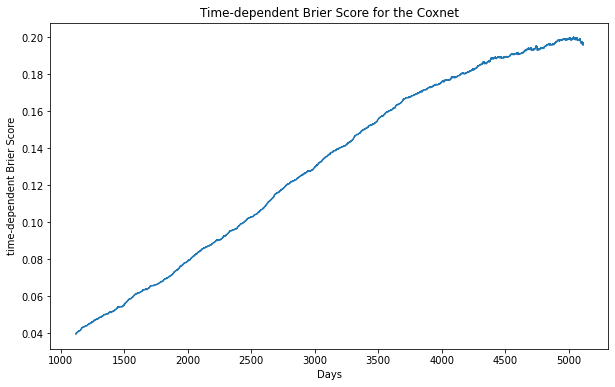

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(cox_bs[0], cox_bs[1], marker=",")
# plt.axhline(ibs, linestyle="--")
# plt.text(5, 0, "{model}", fontsize=12)
plt.title("Time-dependent Brier Score for the Coxnet")
plt.xlabel("Days")
plt.ylabel("time-dependent Brier Score")

Text(0, 0.5, 'time-dependent Brier Score')

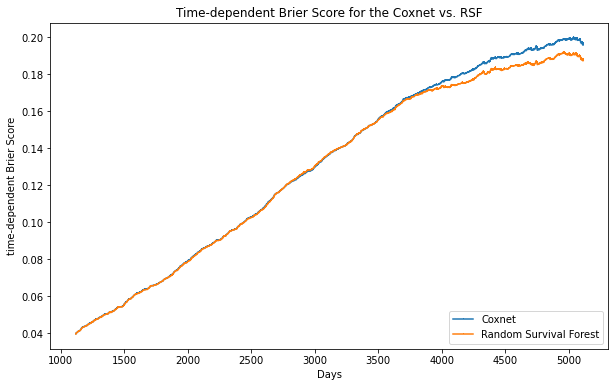

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(cox_bs[0], cox_bs[1], marker=",", label="Coxnet")
plt.plot(bs[0], bs[1], marker=",", label="Random Survival Forest")
# plt.axhline(ibs, linestyle="--")
# plt.text(5, 0, "{model}", fontsize=12)
plt.legend(loc='lower right')
plt.title("Time-dependent Brier Score for the Coxnet vs. RSF")
plt.xlabel("Days")
plt.ylabel("time-dependent Brier Score")

Text(0, 0.5, 'Time-dependent AUC')

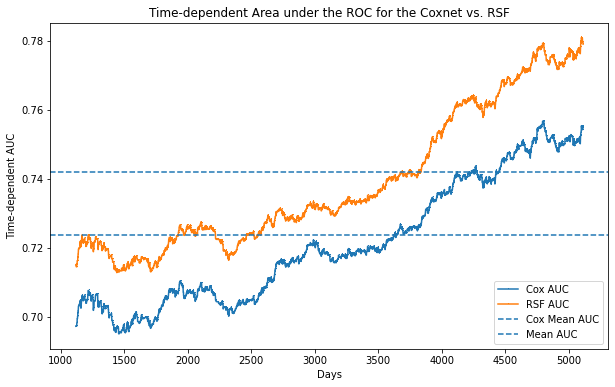

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(times, cox_auc_score, marker=",", label="Cox AUC")
plt.plot(times, auc_score, marker=",", label="RSF AUC")
plt.axhline(cox_mean_auc, linestyle="--", label="Cox Mean AUC")
plt.axhline(mean_auc, linestyle="--", label="Mean AUC")
# plt.text(5, 0, "{model}", fontsize=12)
plt.title("Time-dependent Area under the ROC for the Coxnet vs. RSF")
plt.xlabel("Days")
plt.legend(loc='lower right')
plt.ylabel("Time-dependent AUC")

In [ ]:
cox_ibs

0.13074072519101868

In [ ]:
ibs

0.12877587894572215

In [ ]:
cox_mean_auc

0.7236868193847488

In [ ]:
mean_auc

0.7420656023514658

# RSF finetuning

In [ ]:
from sksurv.ensemble import RandomSurvivalForest
from tqdm import tqdm

# n_estimators = [70, 80, 90]
# max_depth = [5,7]
# min_samples_split = [10, 12, 14]
# max_features = [None]

n_estimators = [30, 50, 70]
max_depth = [6, 8, 10, 12]
min_samples_split = [10, 12, 14]
max_features = [ None]

best_params = None
lowest_ibs = 1
best_rsf_model = None



rsf_gr = RandomSurvivalForest(n_jobs=-1)
pbar = tqdm(total = len(n_estimators)*len(max_depth)*len(min_samples_split)
            *len(max_features), desc='Hyperparameter Tuning')

for n in n_estimators:
    for depth in max_depth:
        for min_split in min_samples_split:
            for max_feat in max_features:
                rsf_gr.set_params(n_estimators=n, 
                                  max_depth=depth, 
                                  min_samples_split=min_split, 
                                  max_features=max_feat)
                rsf_gr, ibs = train_model(rsf_gr, 
                                          X, y)

                # ibs = float(uno[0])
                if ibs < lowest_ibs:
                    lowest_ibs = ibs
                    best_params = (n, depth, min_split, max_feat)
                    best_rsf_model = rsf_gr

                # Update the progress bar
                pbar.update()

# Close the progress bar
pbar.close() 

print(best_params, lowest_ibs)

Hyperparameter Tuning: 783it [2:56:48, 13.55s/it]


TypeError: fit() got an unexpected keyword argument 'fit_baseline_model'

In [ ]:
print(best_params, lowest_ibs)